In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx

from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN, view_parameters, new_parameters, modify_parameters, Inits
from train import Trainer, Dataset
from embedding import Embedding, NodeEmbedding
from experiments import (train_take_embedding, plot_dim1, plot_dimN, plot_correlation_error, get_metrics, 
                         init_GCN, init_model_dataset, train_take_embedding_alreadyinit, 
                         plot_node_emb_1D_perclass, scatter_node_emb,  plot_graph_emb_1D)
from config_valid import Config, TrainingMode
from plot_model import plot_model
from utils import plot_wo_outliers, plot_grafo, plot_grafo2

import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats


from plt_parameters import init_params
init_params()

#from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
#event_acc = EventAccumulator(path="./runs/lr-0.01_epochs45_bs150_neurons-1-8-2_15Sep_16-15-16")
#event_acc.Reload()
# Show all tags in the log file
#print(event_acc.Tags())
#w_times, step_nums, vals = zip(*event_acc.Scalars('Test Loss'))
def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

In [2]:
config_file = "configurations/classification_cm.yml"
config_c = Config(config_file)

In [3]:
gg = GenerateGraph(config_c)
dataset = gg.initialize_dataset(parallel=True)

Generating dataset...
Dataset generated


##### Plot del grafo

Draw edges
Draw nodes
Plot
Draw edges
Draw nodes
Plot


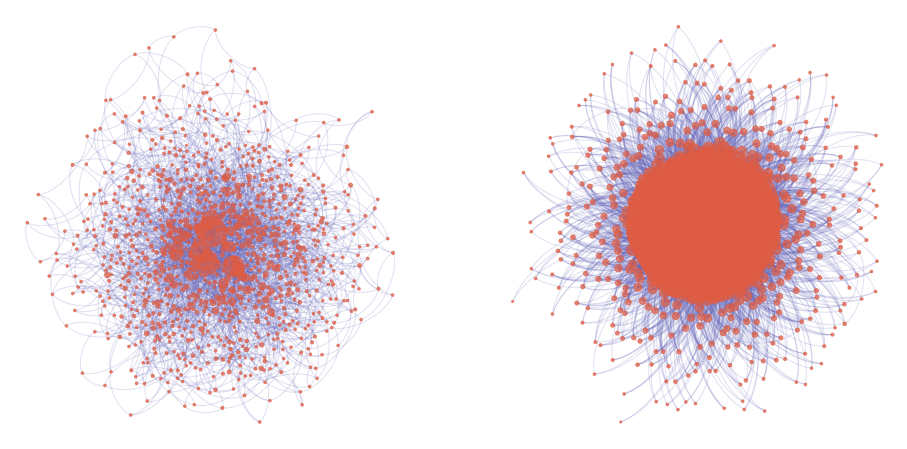

In [4]:
fig, axs = plt.subplots(ncols=2, nrows=1)
G1 = dataset.dataset_list[550]
plot_grafo(axs[0], G1, iterations=1000)   
G2 = dataset.dataset_list[70]
plot_grafo(axs[1], G2, iterations=1000)   

In [5]:
fig.savefig("2grafi.png", dpi=72)

In [4]:
model = init_GCN(config_c, verbose=False)
trainer = Trainer(model, config_c)
trainer.load_dataset(dataset, percentage_train=config_c.conf['training']['percentage_train'], parallel=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 600/600 [00:47<00:00, 12.68it/s]


Tempo impiegato: 47.45336151123047


In [24]:
#view_parameters(model)

In [20]:
model = init_GCN(config_c, verbose=False)

Cambio i parametri...


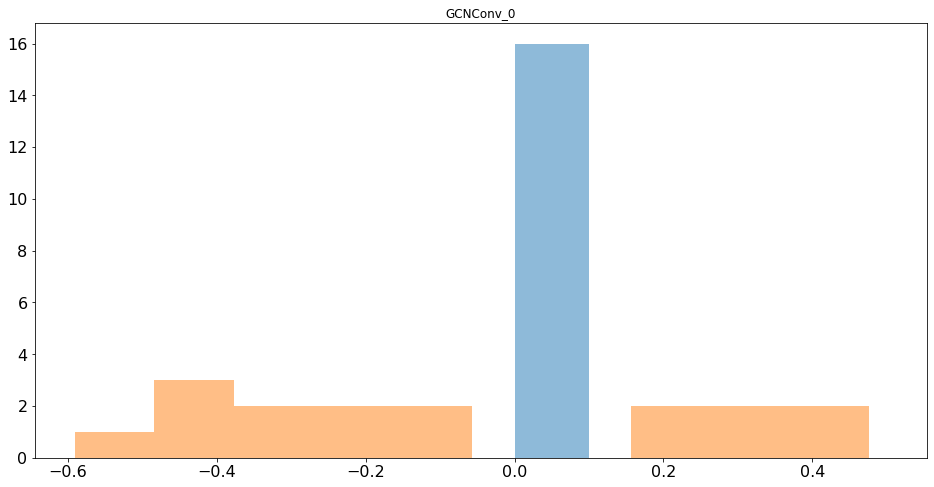

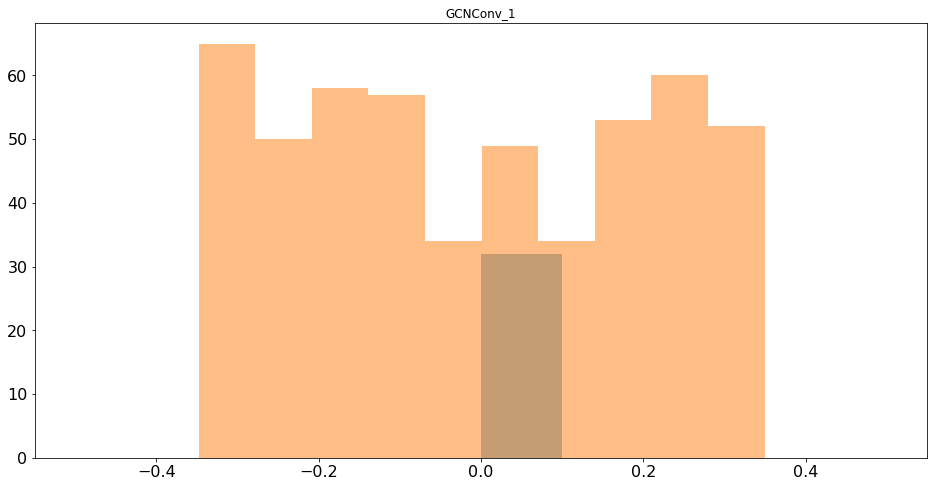

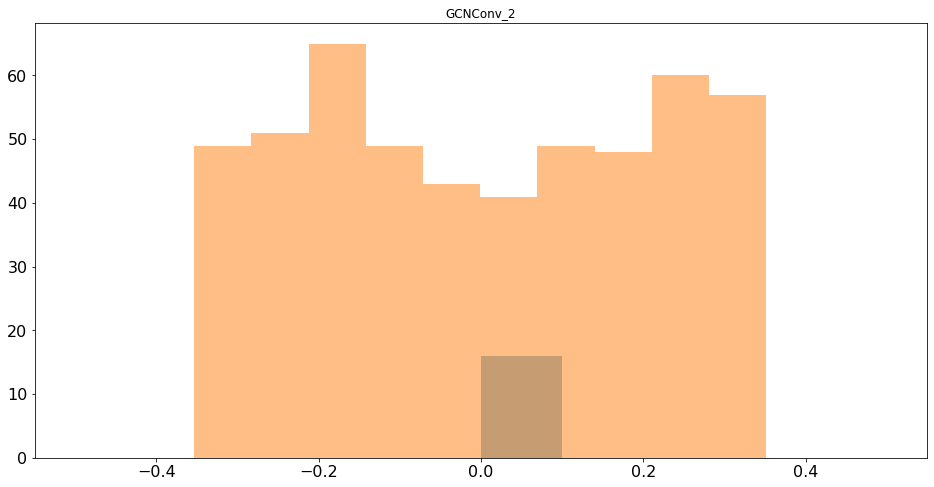

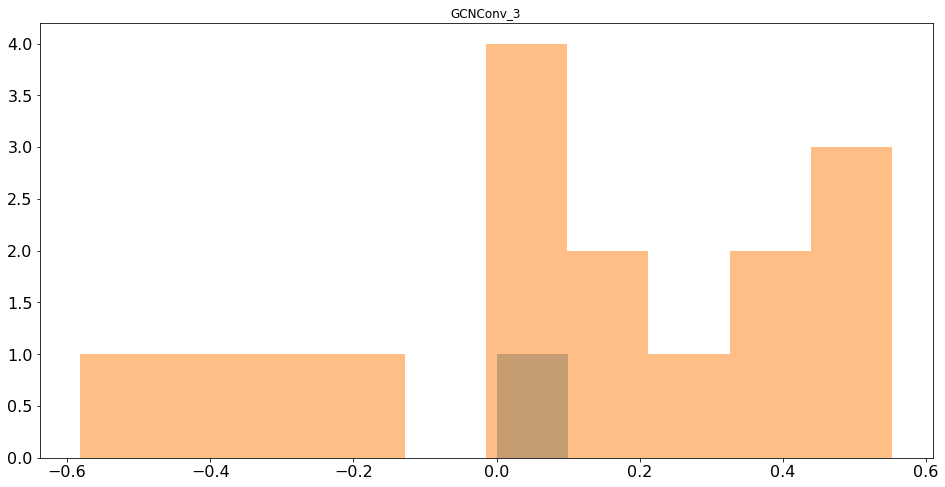

In [21]:
#print("Parametri attuali")
#view_parameters(model)
print("Cambio i parametri...")
new_par = new_parameters(model, method=Inits.kaiming_normal)#, method='esn')
#print(new_par)
#modify_parameters(model, new_par)
#print("Parametri nuovi")
#view_parameters(model)

In [22]:
graph_embeddings_array, node_embeddings_array, node_embeddings_array_id, model, test_loss_list, trainer = train_take_embedding_alreadyinit(trainer, model, config_c) # reinserisco il modello aggiornato #

Before training Test loss: 0.015403220719761319
Run training for 50 epochs
Epoch: 49	Test loss: 3.1883783069335754e-05 		 FINE TRAINING


In [25]:
#view_parameters(model)

In [27]:
graph_embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c)
node_embeddings = NodeEmbedding(node_embeddings_array, node_embeddings_array_id, trainer.dataset, test_loss_list, config_c)

node_emb_pergraphclass = node_embeddings.get_emb_per_graph_class_cm(graph_embeddings_array)

emb_perclass0 = [n for n in node_emb_pergraphclass if n.graph_label == 0]
emb_perclass1 = [n for n in node_emb_pergraphclass if n.graph_label == 1]

## Plot training data degree sequence histogram

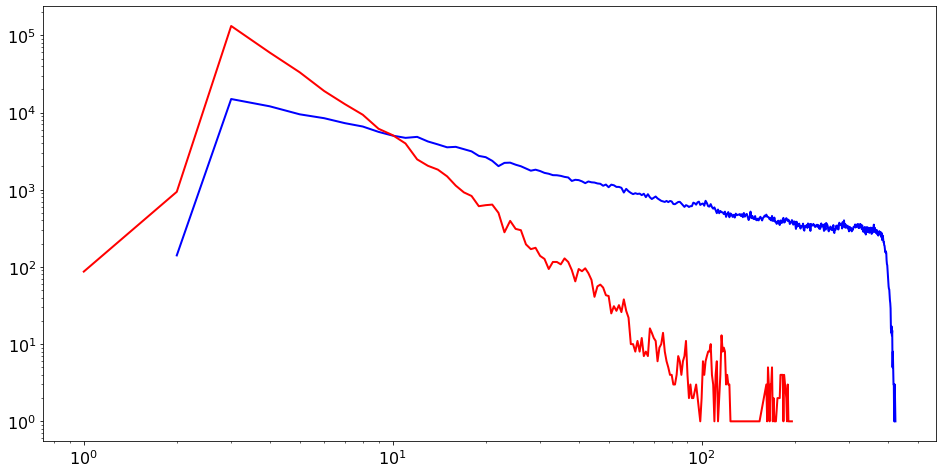

In [9]:
all_nodelabel = [e.node_label for e in emb_perclass0]
counts = np.unique(all_nodelabel, return_counts=True)
plt.loglog(*counts, c='blue')#, alpha=0.1)
all_nodelabel = [e.node_label for e in emb_perclass1]
counts = np.unique(all_nodelabel, return_counts=True)
plt.loglog(*counts, c='red')#, alpha=0.1)

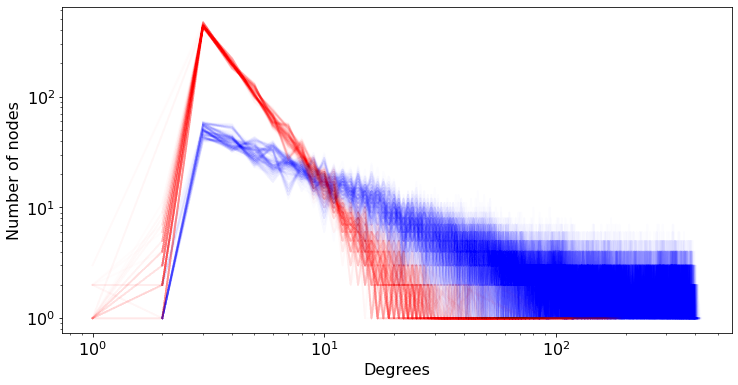

In [10]:
plt.figure(figsize=(12, 6))
exps = config_c.conf['graph_dataset']['list_exponents']
for emb_pergraph in emb_perclass0:
    counts = np.unique(emb_pergraph.node_label, return_counts=True)
    plt.loglog(*counts, c='blue', alpha=0.01, label=exps[emb_pergraph.graph_label])

for emb_pergraph in emb_perclass1:
    counts = np.unique(emb_pergraph.node_label, return_counts=True)
    plt.loglog(*counts, c='red', alpha=0.01, label=exps[emb_pergraph.graph_label])
    
#plt.legend(loc="upper left")
plt.xlabel('Degrees', fontsize=16);
plt.ylabel('Number of nodes', fontsize=16);
#plt.gca().legend(('y0','y1'))
plt.show()

## Plot training data ordered degrees 

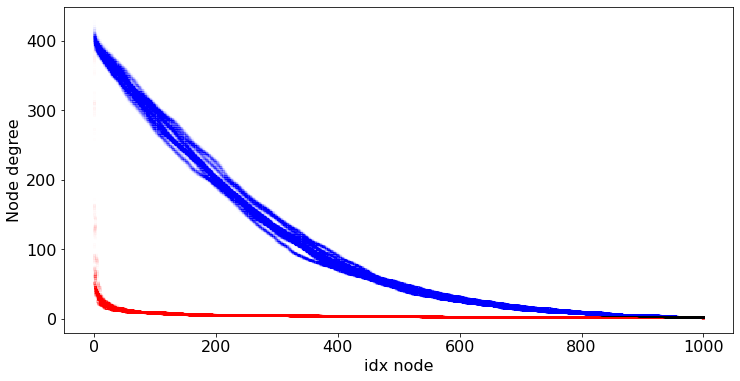

In [28]:
plt.figure(figsize=(12, 6))
for emb_pergraph in emb_perclass0:
    nodeemb_sorted = sorted(emb_pergraph.node_label, reverse=True)
    plt.plot(nodeemb_sorted, '.', c='blue', alpha=0.005)
    #plt.ylim(ymax = max(nodeemb_sorted), ymin = 1)
for emb_pergraph in emb_perclass1:
    nodeemb_sorted = sorted(emb_pergraph.node_label, reverse=True)
    plt.plot(nodeemb_sorted, '.', c='red', alpha=0.005)
    #plt.ylim(ymax = max(nodeemb_sorted), ymin = 1)
    
plt.xlabel('idx node', fontsize=16);
plt.ylabel('Node degree', fontsize=16);
#plt.yscale('log')
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);

## Plot embedding ordered degrees

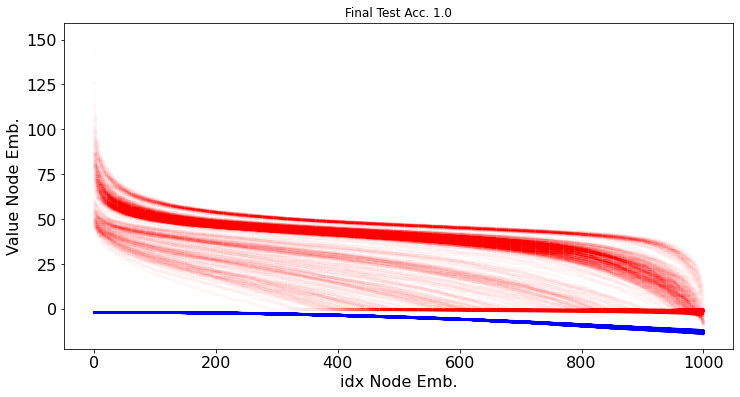

In [29]:
plot_node_emb_1D_perclass(emb_perclass0, emb_perclass1, trainer.last_accuracy)

## Scatter del node embedding vs degree sequence

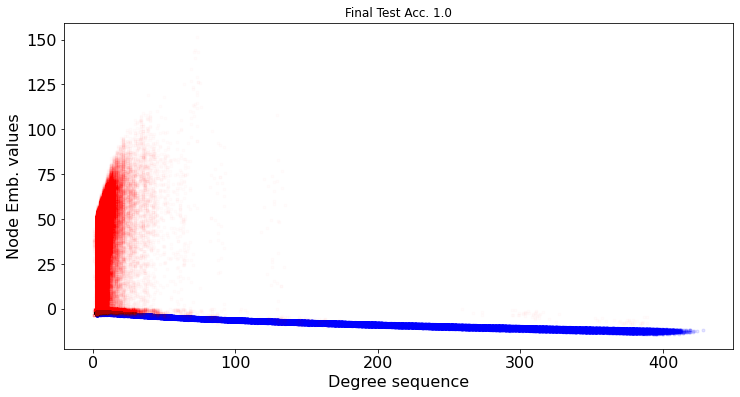

In [30]:
scatter_node_emb(emb_perclass0, emb_perclass1, trainer.last_accuracy)

##### Graph embedding histogram

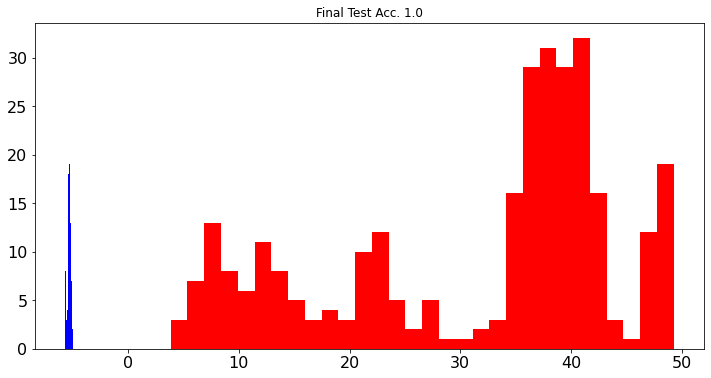

In [31]:
plot_graph_emb_1D(emb_perclass0, emb_perclass1, trainer.last_accuracy)

In [ ]:
# reinizializzo agli stessi valori di sopra
modify_parameters(model, new_par)